In [2]:
import cv2
import numpy as np
from importnb import Notebook
import matplotlib.pyplot as plt
import numpy.fft as fft
import numpy.matlib

In [3]:
with Notebook(): 
        import utils

check file path


In [4]:
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    return cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

In [20]:
def findKernel(img):
    mse = 1000
    for r in range(21, 15, 10):
        for theta in range(45, 360, 400):
            kernel = np.zeros((r, r))
            kernel[r//2,:] = np.ones(r)/r
            kernel = rotateImage(kernel, theta)
            blurr = cv2.filter2D(img, -1, kernel)
            plt.imshow(blurr, cmap ='gray')

In [18]:
def patches(img):
    rows = img.shape[0]
    cols = img.shape[1]
    patch_size = 30
    
    for i in range(0, rows, patch_size):
        ex = min(i + patch_size, rows)
        for j in range(img.shape[1]):
            ey = min(j + patch_size, cols)
            findKernel(img[i:ex, j:ey])
            

image ./resources/test4.jpg loaded


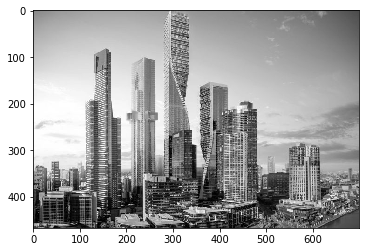

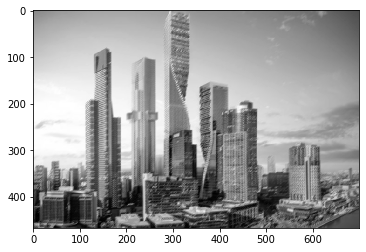

In [21]:
img = utils.loadImage('./resources/test4.jpg', 'gray')
plt.imshow(img, cmap='gray')
plt.show()
findKernel(img)
# print(img)